# Assignment 9: Unsupervised Learning [_/100 Marks]

### <span style="color:red">As we approach the final exam, this last assignment can serve as an indicator of your coding readiness. I urge you to tackle this assignment independently and perhaps in a self-timed setup, without relying on AI tools or seeking assistance from friends. This is a chance for you to assess your own capabilities and ensure that you're prepared for the challenges ahead. By completing this task on your own, you'll gain valuable insights into your strengths and areas for improvement, which will ultimately benefit you in the final exam.</span>

### Once you are finished, ensure to complete the following steps:

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.

---
## Question 1 - <span style="color:green">[100]</span>

You are going to use unsupervised techniques to identify and label the unknown cells in the data set `A9_data.csv` based on the few known cells.

---
### <span style="color:orange">Data Dictionary</span>

The given dataset, `A9_data.csv`, lists certain geometrical characteristics of different cells (each row represents one sample, *i.e.*, a cell) and has the following attributes:

|Column Index| Attribute | Description |
| --- | --- | --- |
|0|`cell_feature_1`|Some measurement pertaining to cell shape (numerical attribute).|
|1|`cell_feature_2`|Some measurement pertaining to cell shape (numerical attribute).|
|2|`cell_feature_3`|Some measurement pertaining to cell shape (numerical attribute).|
|3|`cell_feature_4`|Some measurement pertaining to cell shape (numerical attribute).|
|4|`cell_feature_5`|Some measurement pertaining to cell shape (numerical attribute).|
|5|`cell_feature_6`|Some measurement pertaining to cell shape (numerical attribute).|
|6|`cell_type`|Type of cell (categorical attribute).|


---
### <span style="color:orange">Toolbox</span>

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn.preprocessing as prep
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')
from IPython.display import display
%matplotlib inline

from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

seed = 1151 # work with this seed throughout your work
np.random.seed(seed)


### Q1.1 - <span style="color:red">[10]</span> - Load the dataset as a pandas dataframe and name it `dfc`. Display the first five rows of `dfc`. How many observations are there in `dfc` and for how many of them the cell type is known? Name the known cell types. Then, create a copy of `dfc` and name it `data` and drop the attribute "cell_type" from `data`.

In [33]:
dfc = pd.read_csv("A9_data.csv")

print(f"There are {dfc.shape[0]} observations in dfc")

dfc.value_counts(dfc["cell_type"])
print("The cell type is known for 4 observations and these types are A, B, C, D")

data = dfc.copy()
data.drop("cell_type", axis=1, inplace=True)

dfc.head()


There are 1200 observations in dfc
The cell type is known for 4 observations and these types are A, B, C, D


,cell_feature_1,cell_feature_2,cell_feature_3,cell_feature_4,cell_feature_5,cell_feature_6,cell_type
0,-8.969499,-6.294874,-0.609292,-0.538988,3.045112,3.944128,D
1,3.559447,-8.800391,-9.503687,3.743288,-5.254547,-0.528753,unknown
2,4.198048,-7.418047,-8.449960,3.376891,-7.041192,0.586114,unknown
3,-1.580189,4.640504,-3.702296,7.572398,6.572311,-2.315348,unknown
4,-1.762427,5.716517,-3.511441,9.449469,6.463332,-3.510625,unknown


### Q1.2 - <span style="color:red">[10]</span> - Use `seaborn.pairplot` to investigate pairwise relationships in the dataframe `data`. Could we use this plots to reliably say how many clusters are there in the data? Why?

Hint: You could set the argument `corner` to `True` to speed up the plotting.

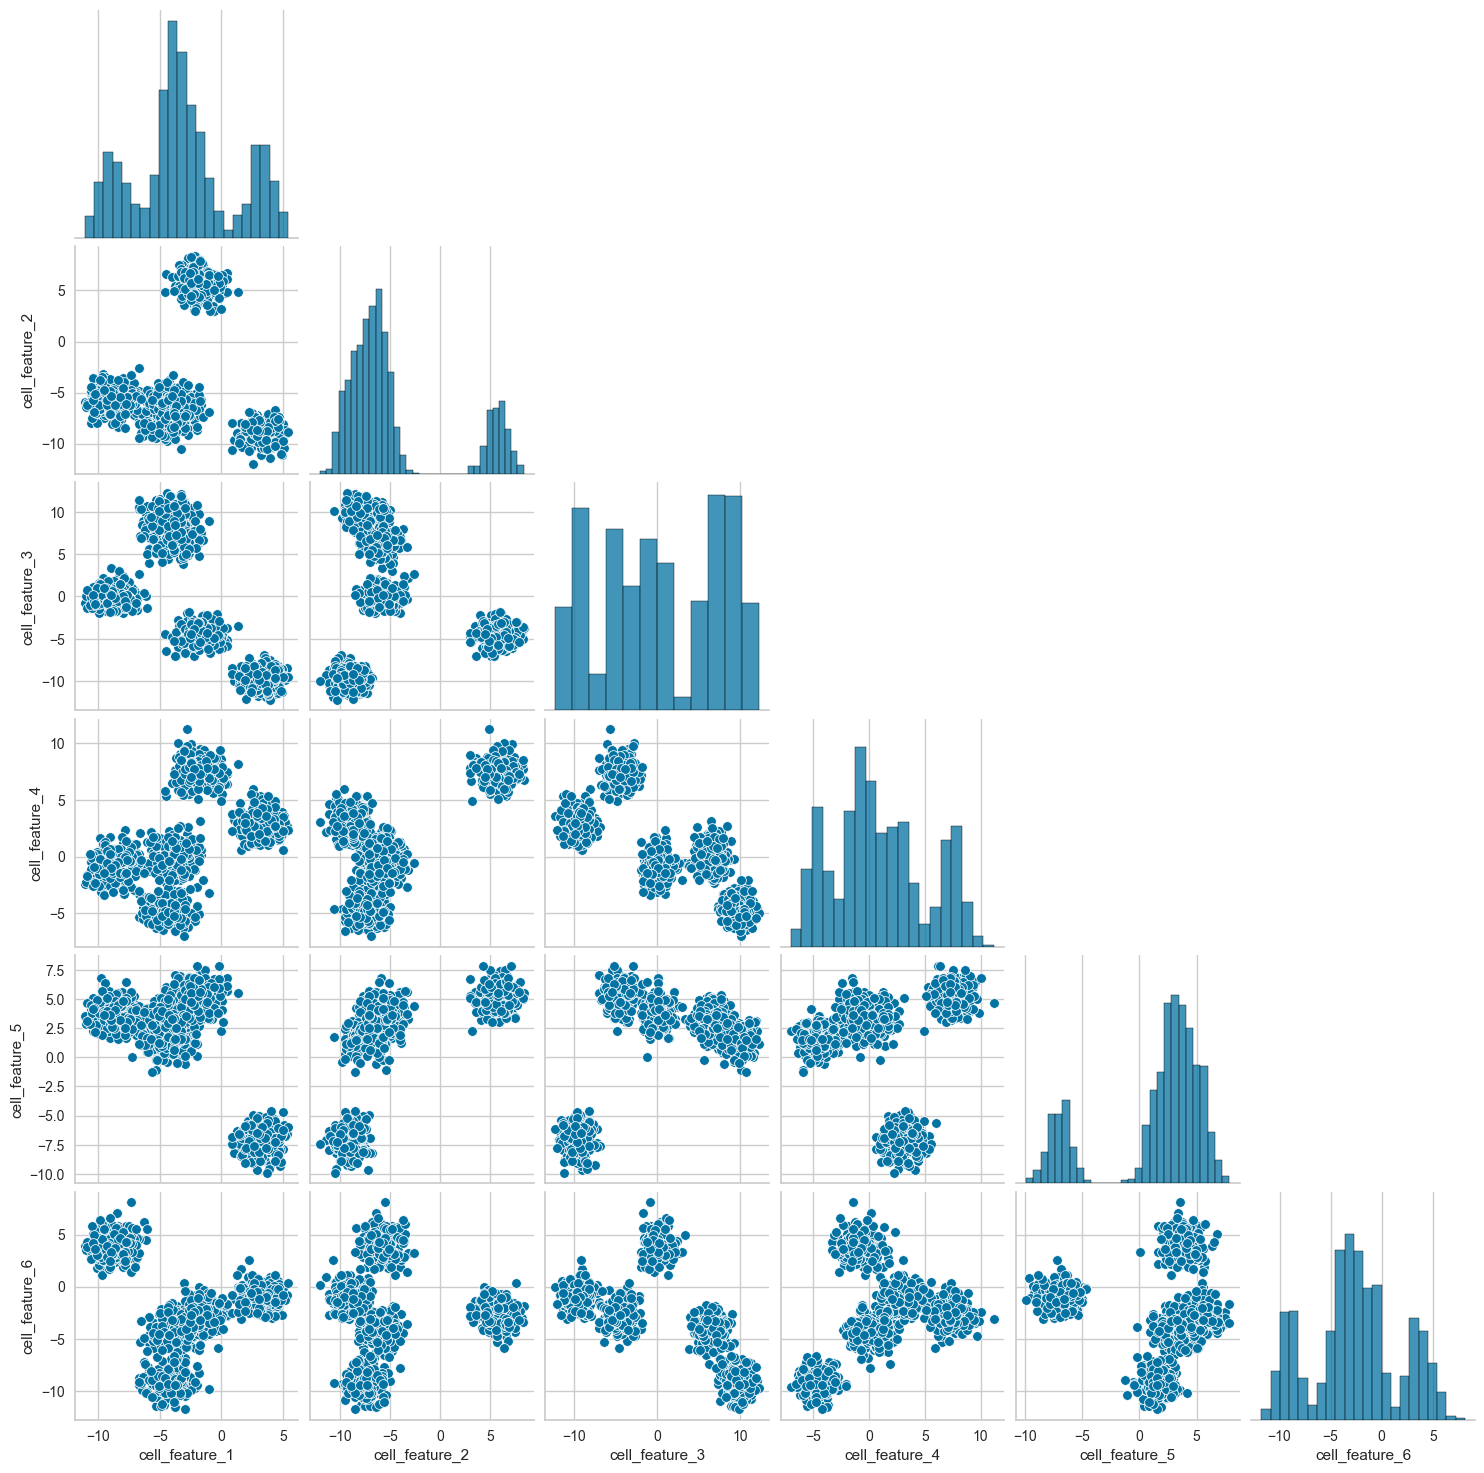

In [34]:
sns.pairplot(data, corner=True)


Using these plots we can see the clustering of each feature when compared to each other but in aggregate we would need to cluster all the features in one plot to reliably determine the number of clusters in the data.

### Q1.3 - <span style="color:red">[15]</span> - Cluster the dataframe `data` using `KMeans` with `k` in $[2, 3, 4, 5, 6]$. Plot inertia versus `k` as well as silhouette score versus `k` in separate plot windows. Solely relying on these two plots, what are the best **two** values that you would conclude for `k`? Why?

In [ ]:
#


### Q1.4 - <span style="color:red">[20]</span> - Do the following steps on the dataframe `data`:
1. Plot the silhouette diagrams (*i.e.*, the stacked silhouette scores for clusters members) for the choices of `k` which you concluded in the previous question (*i.e.*, Q1.2).
2. Do a 2-component PCA and plot PC1 against PC2.
3. Do a 2-component t-SNE with a perplexity of 100 and plot the first embedding against the second embedding.
4. Interpret, in writing, the results of the previous 3 steps. What would be your final choice for the number of clusters (`k`)?

In [ ]:
#


### Q1.5 - <span style="color:red">[30]</span> - Now that you have the number of clusters figured out, use the sample cells with known cell type to update the type of the "unknown" cells in the dataframe `dfc` (which you created in Q1.1) using decision boundaries defined over the t-SNE's first and second embeddings. The decision boundaries that you define could be of any geometric shape (*e.g.*, square) as long as they can perfectly isolate the clusters from each other. Also, plot these:
1.   scatter plot TSNE_embedding_0 vs TSNE_embedding_1, reflecting in a color-coded way, original known cells, unknown cells, and decision boundaries,
2.   scatter plot TSNE_embedding_0 vs TSNE_embedding_1 after updating the cell type of the unknown cells. Use different colors to distinguish the clusters,
3.   scatter plot "cell_feature_1" against "cell_feature_5" color coded by their updated "cell_type". This plot must have a legend indicating what color is referring to what type of cell.

In [ ]:
#


### Q1.6 - <span style="color:red">[15]</span> - This question in independent of Q1.5. This time, we want to update the cell type of the unknown cells using a different method. We have the number of clusters figured out in Q1.4 already. Use the sample cells with known cell type to update the type of the "unknown" cells in the dataframe `dfc` (which you created in Q1.1) using `kmeans.predict()`. Finally, scatter plot "cell_feature_1" against "cell_feature_5" color coded by their updated "cell_type". This plot must have a legend indicating what color is referring to what type of cell.

In [ ]:
#
